# Final project: Compressed sensing decoder

#### Telecom guys: Avdotin Evgeny, Smeshko Anastasiia, Daria Ustinova


# 1. Problem statement

We consider a wireless network that is composed of  $K_{a}$ active users. Every active user wishes to transmit $B$ bits of information to the base station. The number of resources (channel) uses in this process is $N$ and they are split into $V$ slots. Denote the set of $B$-bit messages which corresponds to the set of active users as $\mathbf{W}={\{ w_{1},...,w_{K_{a}}\}}$. Users encode the message index $w_{i}$ into a codeword of length $n$, which after binary phase-shift keying (BPSK) modulation belongs to the alphabet $\{1,-1\}$ (${x}_{w_{i}} \in \{1,-1\}$).

Denote the $\mathcal{N}_{j}$ set of users, who transmit to the $j-$th slot, $j=1,\ldots,V$. Then in each slot we'll receive:
$$
    \mathbf{y}_{j}=\sum_{i\in\mathcal{N}_{j}}{\mathbf{x}_{w_{i}}}+\mathbf{z}_{j},
$$
where $\mathbf{x}_{w_{j}}$ is BPSK modulated codeword transmitted by the $i$-th user and $\mathbf{z}_{j} \sim \mathcal{N}(\mathbf{0}, \sigma^2)$ is an additive Gaussian noise (AWGN).

Thus, in slot we receive the sum of $|\mathcal{N}_{j}|=T$ messages and want to determine each $x_{w_{i}}$. We can represent this sum as a multiplication of matrix $A$ and sparse vector $b_{j}$:

$$
\mathbf{y}_{j} = A b_{j} + \mathbf{z}_{j},
$$
where we consider matrix $A_{n*m}$ - matrix with all possible modulated codewords as columns, $b_{j}$ - activity vector with exactly $T$ ones (on transmitted codewords places) and other zeros.

Consequently, our decoding task can be reduced to searching the right active vector (among all vectors with $T$ ones):

$$
\hat{b} = argmin_{b_j}||A b_j - \mathbf{y}_{j} ||
$$

- If we consider $||.||_{1}$, this problem could be interpreted as compressed sensing problem

- If we consider $||.||_{2}$, this is non-negative least squares problem (NNLS), or bounded-variable least squares (BVLS), because we have rectrictions for vector $b_j$.

# 2. Sensing matrix construction

In [1]:
import numpy as np
import random
import scipy
from scipy.optimize import nnls
import math
from heapq import nlargest

In [2]:
# specify some parameters
k = 3 #number of information bits
n = 7 #length of codeword
T = 2 #number of users in slot

SNR_array = np.arange(-8,5)


#generate information symbols - all possible vectors with length k on alphabet 2**K

def get_info_vectors(q,k):
    temp = np.array([np.arange(q**k)]) # numbers from 0 to q**k-1
    info = temp%q
    temp = np.floor(temp/q)
    for i in range(1,k):
        info = np.concatenate((temp%q,info),axis=0)
        temp = np.floor(temp/q)
    return info

C = get_info_vectors(2**k,k).T

#Kautz - Singleton encoding (this only for q-ary codes) 

C_KS = np.zeros(((2**k)**k,k*2**k))
vector = np.zeros((1,2**k))
vector[0,0] = 1
for i in np.arange(C.shape[0]):
    for j in np.arange(C.shape[1]):
        C_KS[i,(2**k)*j:(2**k)*(j+1)]=np.roll(vector,int(C[i,j]))
        
        
C_KS = 1- 2*C_KS

In [3]:
!pip install pyldpc

We construct out codebook with the help of Low-density parity-check code (LDPC)

In [4]:
from pyldpc import make_ldpc, encode, decode, get_message
n = 35
d_v = 6
d_c = 7
snr = 20
H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
k = G.shape[1]
print(k)

10


In [60]:
A = encode(G,get_info_vectors(2,10),1000) #sensing matrix

## 3. Problem solution 
### 3.1 NNLS: apply non-negative least squares solver from scipy.optimize
This is the method that authors used for solving the problem (https://avinashvem.github.io/unsourcedma.pdf)

In [6]:
num_tests = 2000
N_list = T
N0 = 10**(-SNR_array/10)
sigma_array = np.sqrt(N0/2)
Pr_error_T = np.zeros((1,len(SNR_array)))
#Pr_error_perUser = np.zeros((1,len(SNR_array)))
Mp = 2**k

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Non-negative least squares
        
        b_ls = np.array([nnls(A,y)],dtype=object)[0,0]
        
        cdws = nlargest(N_list, enumerate(b_ls), key=lambda x: x[1])
        
        cdws = sorted(cdws)

        set_idxs = set([cdws[i][0] for i in range(T)])

        #print(set(perm))
        #print(set_idxs)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_T[0,i]=error/test
print(Pr_error_T)

[[0.933   0.88075 0.79575 0.63075 0.4055  0.19425 0.06875 0.0325  0.02275
  0.0135  0.0145  0.012   0.0145 ]]


In [7]:
import matplotlib.pyplot as plt

+ Firstly, we decided to improve authors' solution by adding N_list - search not T maximal, but some number (e.g. N_list = 10). Then we consider all possible combinations $C_{N_{list}}^{T}$ and find the minimum distanse in terms of $||.||_2$

In [8]:
import itertools

In [9]:
num_tests = 2000
N_list = 10
N0 = 10**(-SNR_array/10)
sigma_array = np.sqrt(N0/2)
Pr_error = np.zeros((1,len(SNR_array)))
T = 2

Mp = 2**k

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Non-negative least squares
        
        b_ls = np.array([nnls(A,y)],dtype=object)[0,0]
        
        cdws = nlargest(N_list, enumerate(b_ls), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error[0,i]=error/test

In [61]:
Pr_error = np.array([[0.91875, 0.8525 , 0.7405 , 0.57625, 0.32175, 0.12875, 0.05475, 0.03275, 0.02775, 0.021  , 0.0135 , 0.0195 , 0.014  ]])

In [62]:
Pr_error_T = np.array([[0.933  , 0.88075, 0.79575, 0.63075, 0.4055 , 0.19425, 0.06875, 0.0325 , 0.02275, 0.0135 , 0.0145 , 0.012  , 0.0145 ]])

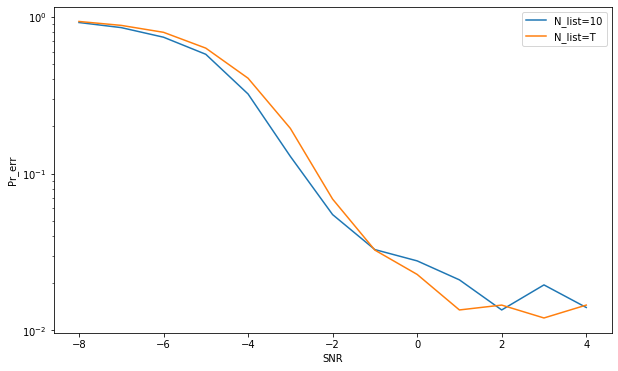

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.semilogy(SNR_array,np.reshape(Pr_error, (1,np.product(Pr_error.shape)))[0],label="N_list=10")
ax.semilogy(SNR_array,np.reshape(Pr_error_T, (1,np.product(Pr_error_T.shape)))[0],label="N_list=T")

ax.set_xlabel("SNR")
ax.set_ylabel("Pr_err")

ax.legend()
plt.show()

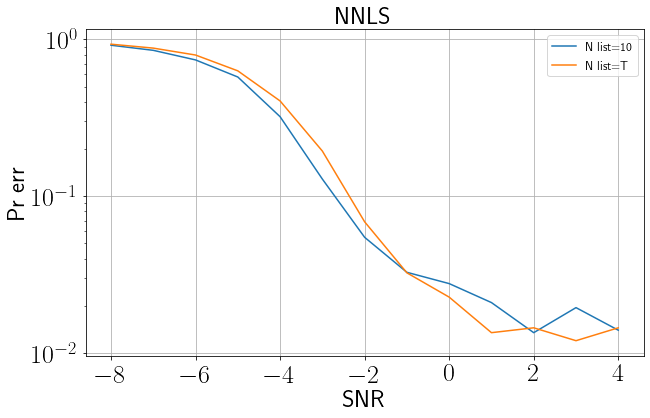

In [67]:
plt.figure(figsize=(10,6))
plt.rc("text", usetex=True)

plt.semilogy(SNR_array,np.reshape(Pr_error, (1,np.product(Pr_error.shape)))[0],label="N list=10")
plt.semilogy(SNR_array,np.reshape(Pr_error_T, (1,np.product(Pr_error_T.shape)))[0],label="N list=T")

plt.grid()
plt.title(r"NNLS", fontsize=24)
plt.ylabel(r"Pr err", fontsize=24)
plt.xlabel(r"SNR", fontsize=24)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.legend(loc=1,fontsize='large')
plt.savefig("NNLS.png")

As we can see, increasing of N_list will lead to increasing in accuracy (and complexity)

### 3.2 Least squares with bounds [0,1] and initial guess  (consider it equiprobable)

In [13]:
from scipy.optimize import least_squares

In [40]:
def leastsq(x):    
    return A@x - y

In [41]:
# initial guess

x0=np.ones(1024)/2

In [68]:
Pr_error_ls = [0.9015, 0.8355, 0.7,    0.52,   0.2425, 0.078,  0.0255, 0.0155, 0.0085, 0.009,  0.005,  0.005,  0.003 ]

In [69]:
Pr_error_ls_T = [0.902,  0.812,  0.6845, 0.544,  0.394,  0.246,  0.1475, 0.0765, 0.044,  0.021,  0.015,  0.0095, 0.0085]

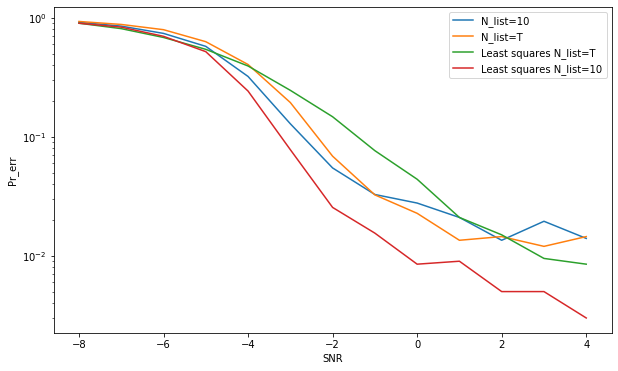

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.semilogy(SNR_array,np.reshape(Pr_error, (1,np.product(Pr_error.shape)))[0],label="N_list=10")
ax.semilogy(SNR_array,np.reshape(Pr_error_T, (1,np.product(Pr_error_T.shape)))[0],label="N_list=T")

ax.semilogy(SNR_array,Pr_error_ls_T,label="Least squares N_list=T")
ax.semilogy(SNR_array,Pr_error_ls,label="Least squares N_list=10")

ax.set_xlabel("SNR")
ax.set_ylabel("Pr_err")

ax.legend()
plt.show()

### 3.3 BVLS


In [17]:
from scipy.optimize import lsq_linear

In [19]:
Pr_error_bv = [0.9065 , 0.83575, 0.72225, 0.508  , 0.25525, 0.088  , 0.023  , 0.01475, 0.005  , 0.006  , 0.0075 , 0.009  , 0.0035 ]

In [ ]:
num_tests = 2000
N_list = T
N0 = 10**(-SNR_array/10)
sigma_array = np.sqrt(N0/2)
Pr_error_bv_T = np.zeros((1,len(SNR_array)))
#Pr_error_perUser = np.zeros((1,len(SNR_array)))
Mp = 2**k

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Non-negative least squares
        
        ans = lsq_linear(A, y, bounds=[0,1], method='bvls')
        
        cdws = nlargest(N_list, enumerate(ans.x), key=lambda x: x[1])
        
        cdws = sorted(cdws)

        set_idxs = set([cdws[i][0] for i in range(T)])

        #print(set(perm))
        #print(set_idxs)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_bv_T[0,i]=error/test
print(Pr_error_bv_T)

[[0.9005  0.83025 0.70225 0.5455  0.37625 0.2415  0.144   0.08475 0.0435
  0.025   0.014   0.011   0.009  ]]


In [20]:
Pr_error_bv_T = [0.9005,  0.83025, 0.70225, 0.5455,  0.37625, 0.2415,  0.144,   0.08475, 0.0435,
  0.025,   0.014,   0.011,   0.009  ]

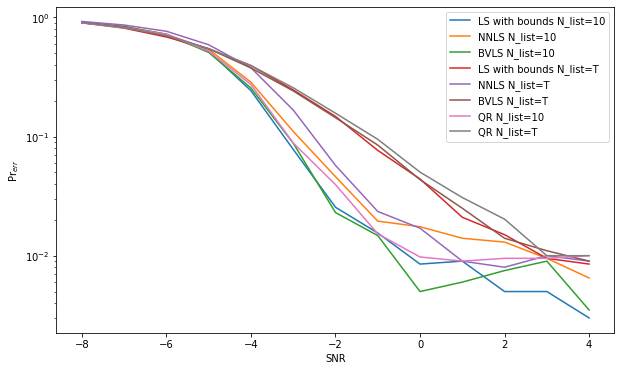

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.semilogy(SNR_array, Pr_error_ls, label="LS with bounds N_list=10")
ax.semilogy(SNR_array,np.reshape(Pr_error, (1,np.product(Pr_error.shape)))[0],label="NNLS N_list=10")
ax.semilogy(SNR_array,Pr_error_bv,label="BVLS N_list=10")
ax.semilogy(SNR_array, Pr_error_ls_T, label="LS with bounds N_list=T")
ax.semilogy(SNR_array,np.reshape(Pr_error_T, (1,np.product(Pr_error_T.shape)))[0],label="NNLS N_list=T")
ax.semilogy(SNR_array,Pr_error_bv_T,label="BVLS N_list=T")
ax.semilogy(SNR_array, np.reshape(Pr_error_qr, (1, np.product(Pr_error_qr.shape)))[0], label="QR N_list=10")
ax.semilogy(SNR_array, np.reshape(Pr_error_T_qr, (1,np.product(Pr_error_T_qr.shape)))[0],label="QR N_list=T")

ax.set_xlabel("SNR")
ax.set_ylabel("$\Pr_{err}$")

ax.legend()
plt.show()

As we can see, BVLS gives better results

### 3.4 Compressed sensing and DCT

In [ ]:
# Here we use just a part of our codebook

In [23]:
from sklearn import linear_model
from scipy.fftpack import dct, idct
from scipy.sparse import coo_matrix
from matplotlib.pyplot import plot, show, figure, title
import numpy as np

In [ ]:
num_part = 100
T = 2
n = 50
code = np.random.randint(2, size=(num_part, n))
num_channel = T*num_part
rand_senders = np.random.choice(np.arange(num_part), size=(num_channel,T))
encoded = 1 - 2*code
after_transmission_code = np.zeros((num_channel, n))
for i in range(num_channel):
    after_transmission_code[i] = encoded[rand_senders[i]].sum(0) +  np.random.normal(scale=1., size=n)

In [ ]:
D = dct(code.T) # Here, we model using the DCT
lasso = linear_model.Lasso(alpha=0.001)# here, we use lasso to minimize the L1 norm
success = 0
for i in range(num_channel):
    lasso.fit(D, after_transmission_code[i])
    # Creates the fourier transform that will most minimize l1 norm 
    recons = idct(lasso.coef_, axis=0)
    num_code = np.argsort(np.abs(recons))[-T-1:]
    if sum([elem in rand_senders[i] for elem in num_code]) == T:
        success += 1
    # else:
    #     print(i, rand_senders[i], num_code)

In [ ]:
success

128

In [24]:
num_tests = 1000
N_list = T
N0 = 10**(-SNR_array/10)
sigma_array = np.sqrt(N0/2)
Pr_error_cs_T = np.zeros((1,len(SNR_array)))
#Pr_error_perUser = np.zeros((1,len(SNR_array)))
A = encode(G,get_info_vectors(2,10),1000) #sensing matrix
Mp = 2**k

In [98]:
choice = sorted(np.random.choice(np.arange(1024), replace=False, size=120))
D = (A[:, choice] - 1) / -2 + 0
D = dct(D)

In [99]:
A_new = A[:, choice]

In [ ]:
# for shape (35, 60)
# for shape (35, 120)
Pr_error_cs = np.zeros((1,len(SNR_array)))
Pr_error_l_bvls = np.zeros((1,len(SNR_array)))
Pr_error_l_nnls = np.zeros((1,len(SNR_array)))
Pr_error_l_qr = np.zeros((1,len(SNR_array)))
lasso = linear_model.Lasso(alpha=0.001)# here, we use lasso to minimize the L1 norm
N_list = 10
T=2
Pr_error_cs = np.zeros((1,len(SNR_array)))

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    error_bvls = 0
    error_nnls = 0
    error_qr = 0

    #error_perUser = 0
    test = 0
    size_ = 60
    while test < 100:
        b = np.zeros((size_,1))
        perm = np.random.permutation(size_)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A_new@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A_new.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Compressive sensing
        
        lasso.fit(D, y)
        # recons = idct(lasso.coef_, axis=0)
        # num_code = np.argsort(np.abs(recons))[-5:]
        
        ans = idct(lasso.coef_, axis=0)
        
        cdws = nlargest(N_list, enumerate(np.abs(ans)), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error = error + (T-len(set_idxs&set(perm)))/T



        ans = lsq_linear(A_new, y, bounds=[0,1], method='bvls')
        
        cdws = nlargest(N_list, enumerate(ans.x), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_bvls = error_bvls + (T-len(set_idxs&set(perm)))/T     




        ans = np.array([nnls(A_new,y)],dtype=object)[0,0]
        
        cdws = nlargest(N_list, enumerate(np.abs(ans)), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_nnls = error_nnls + (T-len(set_idxs&set(perm)))/T



        Q, R = np.linalg.qr(A_new, mode="complete")
        b_qr = np.linalg.pinv(R) @ np.conj(Q.T) @ y 
        cdws = nlargest(N_list, enumerate(b_qr), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_qr = error_qr + (T-len(set_idxs&set(perm)))/T
        
        test = test+1
    Pr_error_cs[0,i]=error/test
    Pr_error_l_bvls[0,i]=error_bvls/test
    Pr_error_l_nnls[0,i]=error_nnls/test
    Pr_error_l_qr[0,i]=error_qr/test

In [ ]:
# for shape (35, 60)
T = 4
Pr_error_cs4 = np.zeros((1,len(SNR_array)))
Pr_error_l_bvls4 = np.zeros((1,len(SNR_array)))
Pr_error_l_nnls4 = np.zeros((1,len(SNR_array)))
Pr_error_l_qr4 = np.zeros((1,len(SNR_array)))
lasso = linear_model.Lasso(alpha=0.001)# here, we use lasso to minimize the L1 norm
N_list = 10

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    error_bvls = 0
    error_nnls = 0
    error_qr = 0

    #error_perUser = 0
    test = 0
    size_ = 60
    while test < 100:
        b = np.zeros((size_,1))
        perm = np.random.permutation(size_)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A_new@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A_new.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Compressive sensing
        
        lasso.fit(D, y)
        # recons = idct(lasso.coef_, axis=0)
        # num_code = np.argsort(np.abs(recons))[-5:]
        
        ans = idct(lasso.coef_, axis=0)
        
        cdws = nlargest(N_list, enumerate(np.abs(ans)), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1] - A_new[:,comb[0][j,:]][:,2]-A_new[:,comb[0][j,:]][:,3])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error = error + (T-len(set_idxs&set(perm)))/T



        ans = lsq_linear(A_new, y, bounds=[0,1], method='bvls')
        
        cdws = nlargest(N_list, enumerate(ans.x), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1] - A_new[:,comb[0][j,:]][:,2]-A_new[:,comb[0][j,:]][:,3])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_bvls = error_bvls + (T-len(set_idxs&set(perm)))/T     




        ans = np.array([nnls(A_new,y)],dtype=object)[0,0]
        
        cdws = nlargest(N_list, enumerate(np.abs(ans)), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1] - A_new[:,comb[0][j,:]][:,2]-A_new[:,comb[0][j,:]][:,3])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_nnls = error_nnls + (T-len(set_idxs&set(perm)))/T



        Q, R = np.linalg.qr(A_new, mode="complete")
        b_qr = np.linalg.pinv(R) @ np.conj(Q.T) @ y 
        cdws = nlargest(N_list, enumerate(b_qr), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1] - A_new[:,comb[0][j,:]][:,2]-A_new[:,comb[0][j,:]][:,3])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_qr = error_qr + (T-len(set_idxs&set(perm)))/T
        
        test = test+1
    Pr_error_cs4[0,i]=error/test
    Pr_error_l_bvls4[0,i]=error_bvls/test
    Pr_error_l_nnls4[0,i]=error_nnls/test
    Pr_error_l_qr4[0,i]=error_qr/test

In [71]:
Pr_error_cs, Pr_error_l_bvls, Pr_error_l_nnls, Pr_error_l_qr

(array([[0.705, 0.585, 0.49 , 0.335, 0.23 , 0.11 , 0.04 , 0.02 , 0.01 ,
         0.   , 0.025, 0.005, 0.   ]]),
 array([[0.63 , 0.525, 0.415, 0.255, 0.165, 0.14 , 0.03 , 0.035, 0.045,
         0.025, 0.035, 0.01 , 0.04 ]]),
 array([[0.72 , 0.64 , 0.495, 0.375, 0.2  , 0.205, 0.055, 0.045, 0.06 ,
         0.025, 0.01 , 0.   , 0.02 ]]),
 array([[0.63 , 0.515, 0.365, 0.175, 0.085, 0.01 , 0.   , 0.   , 0.   ,
         0.   , 0.01 , 0.   , 0.   ]]))

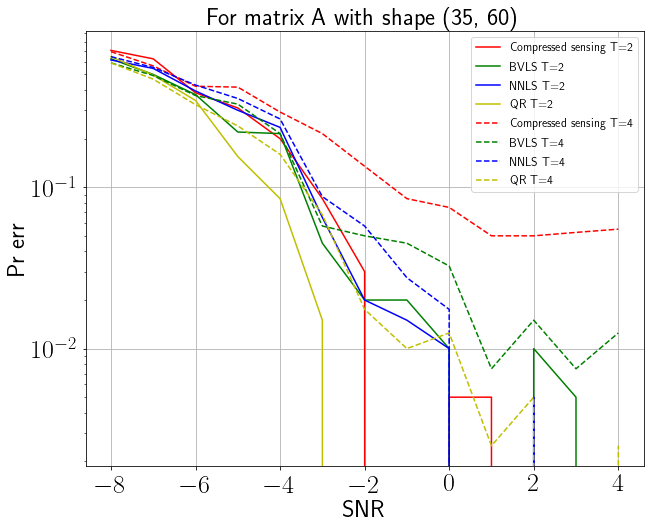

In [97]:
plt.figure(figsize=(10,8))
plt.rc("text", usetex=True)

plt.semilogy(SNR_array,np.reshape(Pr_error_cs, (1,np.product(Pr_error_cs.shape)))[0], color='r',label="Compressed sensing T=2")
plt.semilogy(SNR_array,np.reshape(Pr_error_l_bvls, (1,np.product(Pr_error_l_bvls.shape)))[0], color='g',label="BVLS T=2")
plt.semilogy(SNR_array,np.reshape(Pr_error_l_nnls, (1,np.product(Pr_error_l_nnls.shape)))[0], color='b',label="NNLS T=2")
plt.semilogy(SNR_array,np.reshape(Pr_error_l_qr, (1,np.product(Pr_error_l_qr.shape)))[0], color='y',label="QR T=2")

plt.semilogy(SNR_array,np.reshape(Pr_error_cs4, (1,np.product(Pr_error_cs.shape)))[0],  '--', color='r',label="Compressed sensing T=4")
plt.semilogy(SNR_array,np.reshape(Pr_error_l_bvls4, (1,np.product(Pr_error_l_bvls.shape)))[0], '--', color='g',label="BVLS T=4")
plt.semilogy(SNR_array,np.reshape(Pr_error_l_nnls4, (1,np.product(Pr_error_l_nnls.shape)))[0], '--', color='b', label="NNLS T=4")
plt.semilogy(SNR_array,np.reshape(Pr_error_l_qr4, (1,np.product(Pr_error_l_qr.shape)))[0], '--', color='y', label="QR T=4")

plt.grid()
plt.title(r"For matrix A with shape (35, 60)", fontsize=24)
plt.ylabel(r"Pr err", fontsize=24)
plt.xlabel(r"SNR", fontsize=24)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.legend(loc=1,fontsize='large')
plt.savefig("short_60.png")

In [100]:
# for shape (35, 120)
Pr_error_cs = np.zeros((1,len(SNR_array)))
Pr_error_l_bvls = np.zeros((1,len(SNR_array)))
Pr_error_l_nnls = np.zeros((1,len(SNR_array)))
Pr_error_l_qr = np.zeros((1,len(SNR_array)))
lasso = linear_model.Lasso(alpha=0.001)# here, we use lasso to minimize the L1 norm
N_list = 10
T=2
Pr_error_cs = np.zeros((1,len(SNR_array)))

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    error_bvls = 0
    error_nnls = 0
    error_qr = 0

    #error_perUser = 0
    test = 0
    size_ = 120
    while test < 100:
        b = np.zeros((size_,1))
        perm = np.random.permutation(size_)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A_new@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A_new.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Compressive sensing
        
        lasso.fit(D, y)
        # recons = idct(lasso.coef_, axis=0)
        # num_code = np.argsort(np.abs(recons))[-5:]
        
        ans = idct(lasso.coef_, axis=0)
        
        cdws = nlargest(N_list, enumerate(np.abs(ans)), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error = error + (T-len(set_idxs&set(perm)))/T



        ans = lsq_linear(A_new, y, bounds=[0,1], method='bvls')
        
        cdws = nlargest(N_list, enumerate(ans.x), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_bvls = error_bvls + (T-len(set_idxs&set(perm)))/T     




        ans = np.array([nnls(A_new,y)],dtype=object)[0,0]
        
        cdws = nlargest(N_list, enumerate(np.abs(ans)), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_nnls = error_nnls + (T-len(set_idxs&set(perm)))/T



        Q, R = np.linalg.qr(A_new, mode="complete")
        b_qr = np.linalg.pinv(R) @ np.conj(Q.T) @ y 
        cdws = nlargest(N_list, enumerate(b_qr), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_qr = error_qr + (T-len(set_idxs&set(perm)))/T
        
        test = test+1
    Pr_error_cs[0,i]=error/test
    Pr_error_l_bvls[0,i]=error_bvls/test
    Pr_error_l_nnls[0,i]=error_nnls/test
    Pr_error_l_qr[0,i]=error_qr/test

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5185082881604717, tolerance: 0.02603739016706245
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.448036874914491, tolerance: 0.05255863183058439
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6300669651798745, tolerance: 0.046406577402287395
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.514137126177744, tolerance: 0.03427614366365342
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4890171532806473, tolerance: 0.029244346366996476
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.520182292763216, tolerance: 0.04679427751675458
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the num

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.018038753817535, tolerance: 0.039005796754104906
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.162180643019129, tolerance: 0.04519089796023031
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9954469234439287, tolerance: 0.03581360636007614
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the num

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24898908858805446, tolerance: 0.016379771790009885
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.892900698715744, tolerance: 0.02321653036584
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06599124759470268, tolerance: 0.02640088962938823
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the num

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9282837336086338, tolerance: 0.022989161402223988
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.031115344294343, tolerance: 0.030591458832975295
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4811818365287679, tolerance: 0.02732687540888916
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the n

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0734154191115612, tolerance: 0.025481039310217984
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9453306551993421, tolerance: 0.02356695742338115
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1117665509151298, tolerance: 0.02504964518879638
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the n

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08801155059218851, tolerance: 0.020757373393761748
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06288610566294654, tolerance: 0.02502084622388661
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6070702683553764, tolerance: 0.020836107831499556
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase th

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6540795446830661, tolerance: 0.020122035087069695
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2842681796079165, tolerance: 0.02454647978121497
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.040307328915563136, tolerance: 0.0237972896887428
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05688309454646838, tolerance: 0.021853679863648404
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3983402606120965, tolerance: 0.025882183545572333
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8917623348565016, tolerance: 0.019631516695602515
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase th

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0786422449601708, tolerance: 0.01417466980442967
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.103721082950287, tolerance: 0.0198289892157746
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9118747653657217, tolerance: 0.01130490733711678
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the numb

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0123192577555504, tolerance: 0.0158072177292132
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03237141118846338, tolerance: 0.010438248705546757
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017229405319586007, tolerance: 0.010001550293225584
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase th

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05357502984973511, tolerance: 0.007872093400899857
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02679980226813783, tolerance: 0.013059065103135623
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03064855940510961, tolerance: 0.008596213432852188
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08320351987381691, tolerance: 0.01317901751286434
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032699962945076946, tolerance: 0.013807244851295083
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024017198162926932, tolerance: 0.009391728918304042
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035756550898061124, tolerance: 0.009268008480619401
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04317327309538479, tolerance: 0.015380958399247087
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.040404963412432514, tolerance: 0.018612764823512984
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increas

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03452952969279771, tolerance: 0.016467315036221182
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18087070783173242, tolerance: 0.009545856023672965
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14108382314260548, tolerance: 0.01158027984806185
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase t

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.041086583755074284, tolerance: 0.011498407948417933
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09068485901699264, tolerance: 0.01115870313232721
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45540699569514265, tolerance: 0.011065360198202994
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024466553531165794, tolerance: 0.00930625768386678
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03719520849187896, tolerance: 0.010566078983835742
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05751650019343296, tolerance: 0.01109845694929135
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase t

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08596711214927111, tolerance: 0.006625877012095546
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029961316946832822, tolerance: 0.009187474374407086
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12851432512031624, tolerance: 0.009766414575283015
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016623677435217872, tolerance: 0.011276770185610026
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06001059801770364, tolerance: 0.011417621449276962
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03165990261282382, tolerance: 0.01019998793616583
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05825102872662763, tolerance: 0.010777437525159046
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0716706779680008, tolerance: 0.009519474513894446
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019887603240379893, tolerance: 0.00938261057738302
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase t

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029046609697545994, tolerance: 0.008801222866070348
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16754313351232375, tolerance: 0.009641315664013494
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031232331691981363, tolerance: 0.007077353536425124
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increas

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02222475302685728, tolerance: 0.008264047591875396
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027647013601651532, tolerance: 0.010647546909475378
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08362240668227017, tolerance: 0.00916063085013848
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0370253664541606, tolerance: 0.007993774326823194
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07378771879507007, tolerance: 0.009276967396473155
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05528172648892568, tolerance: 0.004577595697452097
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase t

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018530110332670546, tolerance: 0.007063205630721769
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02376256123919661, tolerance: 0.010589531701547398
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026583809893761162, tolerance: 0.007506167961017022
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increas

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12159353787128269, tolerance: 0.0072020313965282775
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028662490941228864, tolerance: 0.009910979169088714
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016252389739951856, tolerance: 0.005443742521357456
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0104267433240967, tolerance: 0.006230274362777133
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0180778508720219, tolerance: 0.008137442136658244
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01864734522529735, tolerance: 0.007120168828620516
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase th

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024581051569081035, tolerance: 0.011616528637538067
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01085847491319731, tolerance: 0.006868818893556992
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01995910538422399, tolerance: 0.005256362706520107
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03568292542633704, tolerance: 0.006371276388528603
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012025347958256515, tolerance: 0.0038633694862506666
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04856250609013246, tolerance: 0.006164781161267986
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increas

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030247387520382543, tolerance: 0.007570704477558292
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01828428742579913, tolerance: 0.00788940809615997
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011217926234815483, tolerance: 0.0064331711834845155
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increas

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018676144270774922, tolerance: 0.008877251999478574
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.055944753941830766, tolerance: 0.007323954237069977
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018232633914042774, tolerance: 0.007236277261471693
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021054782189508018, tolerance: 0.007912330368027272
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018780795974078918, tolerance: 0.007532103961912913
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01777596280219201, tolerance: 0.007162353557130877
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increas

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01465505471387911, tolerance: 0.006535668458172316
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06380197468976995, tolerance: 0.00846549359463808
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026603607779864508, tolerance: 0.00631751067911468
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase t

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018747768967100068, tolerance: 0.006249305359020288
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013123766194352786, tolerance: 0.005894872610408942
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.043306585687650584, tolerance: 0.006904126001258452
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018574088022991302, tolerance: 0.0059526588613972075
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016637945356918014, tolerance: 0.007651770779372803
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026170389045072767, tolerance: 0.00687543101683732
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024192073311582546, tolerance: 0.00575119039382914
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01678756258993386, tolerance: 0.005338583745688736
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024100898547221725, tolerance: 0.0076799086540700785
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increas

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020033821712257264, tolerance: 0.007631523196401512
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01414611487694483, tolerance: 0.006367952784884253
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03368254489469156, tolerance: 0.006071326644056765
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021178132740625393, tolerance: 0.007833869235856716
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0205302614362933, tolerance: 0.006817075357728667
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023663846274539335, tolerance: 0.008645458349320201
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012059394774266968, tolerance: 0.004651903711729414
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012700686107622695, tolerance: 0.005854035389514397
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01674464930069883, tolerance: 0.00736612440965978
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01279326693520846, tolerance: 0.005108893606853623
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0193556922337632, tolerance: 0.0077930311627643824
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013378904641763063, tolerance: 0.006491246591782992
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase

In [101]:
# for shape (35, 120)
T = 4
Pr_error_cs4 = np.zeros((1,len(SNR_array)))
Pr_error_l_bvls4 = np.zeros((1,len(SNR_array)))
Pr_error_l_nnls4 = np.zeros((1,len(SNR_array)))
Pr_error_l_qr4 = np.zeros((1,len(SNR_array)))
lasso = linear_model.Lasso(alpha=0.001)# here, we use lasso to minimize the L1 norm
N_list = 10

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    error_bvls = 0
    error_nnls = 0
    error_qr = 0

    #error_perUser = 0
    test = 0
    size_ = 120
    while test < 100:
        b = np.zeros((size_,1))
        perm = np.random.permutation(size_)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A_new@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A_new.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Compressive sensing
        
        lasso.fit(D, y)
        # recons = idct(lasso.coef_, axis=0)
        # num_code = np.argsort(np.abs(recons))[-5:]
        
        ans = idct(lasso.coef_, axis=0)
        
        cdws = nlargest(N_list, enumerate(np.abs(ans)), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1] - A_new[:,comb[0][j,:]][:,2]-A_new[:,comb[0][j,:]][:,3])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error = error + (T-len(set_idxs&set(perm)))/T



        ans = lsq_linear(A_new, y, bounds=[0,1], method='bvls')
        
        cdws = nlargest(N_list, enumerate(ans.x), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1] - A_new[:,comb[0][j,:]][:,2]-A_new[:,comb[0][j,:]][:,3])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_bvls = error_bvls + (T-len(set_idxs&set(perm)))/T     




        ans = np.array([nnls(A_new,y)],dtype=object)[0,0]
        
        cdws = nlargest(N_list, enumerate(np.abs(ans)), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1] - A_new[:,comb[0][j,:]][:,2]-A_new[:,comb[0][j,:]][:,3])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_nnls = error_nnls + (T-len(set_idxs&set(perm)))/T



        Q, R = np.linalg.qr(A_new, mode="complete")
        b_qr = np.linalg.pinv(R) @ np.conj(Q.T) @ y 
        cdws = nlargest(N_list, enumerate(b_qr), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A_new[:,comb[0][j,:]][:,0]-A_new[:,comb[0][j,:]][:,1] - A_new[:,comb[0][j,:]][:,2]-A_new[:,comb[0][j,:]][:,3])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)
        error_qr = error_qr + (T-len(set_idxs&set(perm)))/T
        
        test = test+1
    Pr_error_cs4[0,i]=error/test
    Pr_error_l_bvls4[0,i]=error_bvls/test
    Pr_error_l_nnls4[0,i]=error_nnls/test
    Pr_error_l_qr4[0,i]=error_qr/test

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7026961389436455, tolerance: 0.0418019099661814
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13123445068189862, tolerance: 0.04179521969356734
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5436073175717393, tolerance: 0.03284748465505705
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.532250661980715, tolerance: 0.04920995757650296
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2383918124607226, tolerance: 0.05321707806840542
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0871802340632924, tolerance: 0.041668088407611804
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9433422417277315, tolerance: 0.04972579542885439
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5190389328660685, tolerance: 0.052406238744073984
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2627846752118288, tolerance: 0.029852808040328128
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05862482320598968, tolerance: 0.0272220359996337
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3003403390113244, tolerance: 0.06544379290947044
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6824066276378398, tolerance: 0.04437951035893435
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.058797030123422425, tolerance: 0.03927196363339576
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1615243070576589, tolerance: 0.039612982965895174
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16704797356793266, tolerance: 0.04097151255172596
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase th

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2952585503566758, tolerance: 0.021252092018973576
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6595409895249942, tolerance: 0.04236144434323391
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23728388505077103, tolerance: 0.04223826939834037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.404104911767517, tolerance: 0.04355809901285491
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.40675744403269265, tolerance: 0.03292474998658561
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.662641534703951, tolerance: 0.02933243180566816
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the num

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12140410166514004, tolerance: 0.026590460369331777
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1953946431331355, tolerance: 0.028267864988712577
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24561181816475508, tolerance: 0.021292613783997383
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase t

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06694831829450697, tolerance: 0.03233162118899234
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0888430508111791, tolerance: 0.022820843451747636
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.046521244963565564, tolerance: 0.028331924419054407
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase t

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3663688664767335, tolerance: 0.020453310676247713
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.36366022938785325, tolerance: 0.023929117462383607
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1878342711243033, tolerance: 0.01807049349876734
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1357163457199293, tolerance: 0.024409530648476247
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05884572935132591, tolerance: 0.02710214093284962
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0826875960802046, tolerance: 0.02236914153967166
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.197027715549062, tolerance: 0.020356205726643893
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06414319608538632, tolerance: 0.03143802121751631
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1609072061125945, tolerance: 0.022235632740306977
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035135429300424355, tolerance: 0.024072379778538388
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09993933824829204, tolerance: 0.019706906383621794
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6734194306511752, tolerance: 0.017358038743207113
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02998186594646559, tolerance: 0.019841952227492396
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1858528163054971, tolerance: 0.028135227779683056
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1147434355272064, tolerance: 0.01702903015988044
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13226320161792163, tolerance: 0.017451197504649362
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2264540181925323, tolerance: 0.011959687208082458
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07875403256098173, tolerance: 0.015299567931676316
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase t

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035304267107600804, tolerance: 0.01433461545213466
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16511460421726287, tolerance: 0.024483395487965902
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03048951735030876, tolerance: 0.013855457588972268
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07573674919789469, tolerance: 0.017782569092828333
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1791039643332173, tolerance: 0.015723393299174028
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47432431695077204, tolerance: 0.015283160827321694
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase t

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0712887377312865, tolerance: 0.01547846990983502
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15478577183365472, tolerance: 0.01182827588836628
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.037621053799371244, tolerance: 0.013909569431276973
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase th

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0326210508837219, tolerance: 0.01804529842789974
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2514747182412719, tolerance: 0.012173921746852907
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07585862614241959, tolerance: 0.015736916090872497
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2170130701632076, tolerance: 0.010523372159078755
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21995792086068433, tolerance: 0.015646003042075477
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0457419387003235, tolerance: 0.017662288881315148
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase th

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029830978593703424, tolerance: 0.011431061009041942
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028945588989403356, tolerance: 0.01607690360882558
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07396469767529204, tolerance: 0.01351952212024899
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09092919117881165, tolerance: 0.015793449697468816
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07996612341592546, tolerance: 0.01950893777318319
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07867619131088344, tolerance: 0.01750037971679676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase th

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18969864332710884, tolerance: 0.019829181477967323
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05296600417884187, tolerance: 0.015143374973139747
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031095443355350152, tolerance: 0.014009920685928984
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029422378556711343, tolerance: 0.011676578284269674
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030339629102539498, tolerance: 0.016475207939905607
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03556824519221792, tolerance: 0.011025682853808087
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increas

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04735557103224383, tolerance: 0.012150120936195498
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01729456928132908, tolerance: 0.011704339015773595
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03341259447502869, tolerance: 0.012030651676165953
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025456551553208882, tolerance: 0.01821075195989
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030088528723567192, tolerance: 0.01532410437652649
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022766422047242486, tolerance: 0.01207251553271236
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0499456986433714, tolerance: 0.020985177664314115
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04393853713874079, tolerance: 0.014891601967559448
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029411554790033524, tolerance: 0.013241958912527366
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.043898158044827294, tolerance: 0.012510216864301118
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02810157253898858, tolerance: 0.011997504045077656
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016634495270083774, tolerance: 0.009299207983074258
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increas

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.040232842383608795, tolerance: 0.01826495200795564
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10334422046093142, tolerance: 0.017690210532659463
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03092161426986076, tolerance: 0.012386128794981537
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1074463791622009, tolerance: 0.01394526424106324
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0341854561096163, tolerance: 0.014104384816821034
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03370840362534379, tolerance: 0.018895633950702637
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028901027090473284, tolerance: 0.010267435655143174
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03498096719129708, tolerance: 0.013318446321825076
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02785103176320878, tolerance: 0.014950330980044675
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.058312468171180604, tolerance: 0.019975031392770858
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025296728199545294, tolerance: 0.013058863108268487
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03744101778372502, tolerance: 0.014845701619726268
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increas

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08663094637321034, tolerance: 0.01467055318603055
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06430217393108617, tolerance: 0.013831515899232986
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02361613553525494, tolerance: 0.013006210469023831
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase t

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027467610718470134, tolerance: 0.013506896740352102
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.045818280083477436, tolerance: 0.010100197049008693
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.041257900575836975, tolerance: 0.015354456105528002
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05293931774293864, tolerance: 0.014379699367281087
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03324230797466811, tolerance: 0.014659391525947781
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07793628551692477, tolerance: 0.016679252598789267
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02120898841819343, tolerance: 0.008002758933623316
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030518086270672276, tolerance: 0.015271191881615204
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03577368435950824, tolerance: 0.012556603964768391
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022262085512513272, tolerance: 0.008835053669256748
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04338733711577372, tolerance: 0.017586806795874304
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029500684564845246, tolerance: 0.01491058586596771
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.040443213298502534, tolerance: 0.013277310149432755
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02947714071859016, tolerance: 0.012857892066298547
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03653379052278996, tolerance: 0.01812983237121519
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020743835235914387, tolerance: 0.01047718748534177
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03879666924889427, tolerance: 0.015523971262593396
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024902727535762417, tolerance: 0.015914026354648444
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013934864381662096, tolerance: 0.006422341066454493
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030030647098902068, tolerance: 0.01360835115092898
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019607738347171427, tolerance: 0.009894752422620726
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increas

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029471989023340653, tolerance: 0.016275416661726536
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015560006163397472, tolerance: 0.010219627394898711
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03077403863659791, tolerance: 0.012138325704481895
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increas

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028373227172305487, tolerance: 0.014435414067151172
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020097703286308135, tolerance: 0.010558975448245146
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025910961022073624, tolerance: 0.010413388747245006
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03201836232682927, tolerance: 0.016072653893859618
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018729904686568977, tolerance: 0.011137681949141248
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04134563209951817, tolerance: 0.015865191506837586
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03368744119173997, tolerance: 0.015130020264237152
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024491589126163255, tolerance: 0.014535442783313528
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030722102454155423, tolerance: 0.018009343239218573
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increas

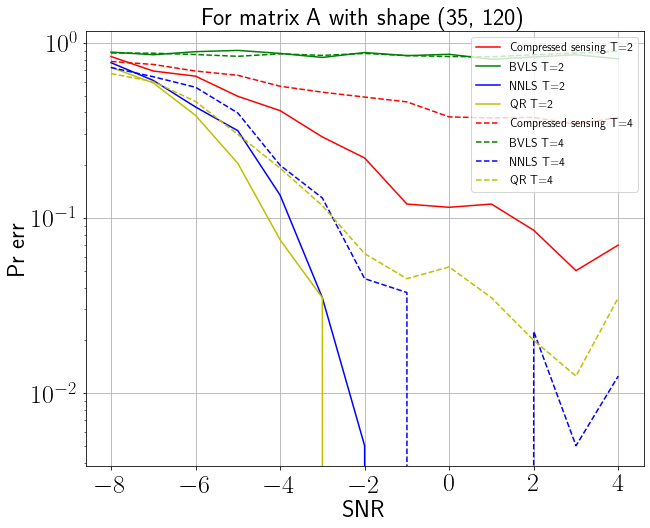

In [102]:
plt.figure(figsize=(10,8))
plt.rc("text", usetex=True)

plt.semilogy(SNR_array,np.reshape(Pr_error_cs, (1,np.product(Pr_error_cs.shape)))[0], color='r',label="Compressed sensing T=2")
plt.semilogy(SNR_array,np.reshape(Pr_error_l_bvls, (1,np.product(Pr_error_l_bvls.shape)))[0], color='g',label="BVLS T=2")
plt.semilogy(SNR_array,np.reshape(Pr_error_l_nnls, (1,np.product(Pr_error_l_nnls.shape)))[0], color='b',label="NNLS T=2")
plt.semilogy(SNR_array,np.reshape(Pr_error_l_qr, (1,np.product(Pr_error_l_qr.shape)))[0], color='y',label="QR T=2")

plt.semilogy(SNR_array,np.reshape(Pr_error_cs4, (1,np.product(Pr_error_cs.shape)))[0],  '--', color='r',label="Compressed sensing T=4")
plt.semilogy(SNR_array,np.reshape(Pr_error_l_bvls4, (1,np.product(Pr_error_l_bvls.shape)))[0], '--', color='g',label="BVLS T=4")
plt.semilogy(SNR_array,np.reshape(Pr_error_l_nnls4, (1,np.product(Pr_error_l_nnls.shape)))[0], '--', color='b', label="NNLS T=4")
plt.semilogy(SNR_array,np.reshape(Pr_error_l_qr4, (1,np.product(Pr_error_l_qr.shape)))[0], '--', color='y', label="QR T=4")

plt.grid()
plt.title(r"For matrix A with shape (35, 120)", fontsize=24)
plt.ylabel(r"Pr err", fontsize=24)
plt.xlabel(r"SNR", fontsize=24)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.legend(loc=1,fontsize='large')
plt.savefig("short_120.png")

In [31]:
Pr_error_cs, Pr_error_l_bvls, Pr_error_l_nnls, Pr_error_l_qr

(array([[0.76  , 0.7025, 0.645 , 0.575 , 0.4825, 0.465 , 0.4425, 0.4175,
         0.395 , 0.38  , 0.38  , 0.37  , 0.3625]]),
 array([[0.6825, 0.6075, 0.58  , 0.5225, 0.49  , 0.455 , 0.4475, 0.45  ,
         0.475 , 0.4125, 0.4125, 0.4075, 0.4275]]),
 array([[0.8225, 0.7675, 0.6975, 0.7   , 0.625 , 0.555 , 0.555 , 0.48  ,
         0.4625, 0.44  , 0.4   , 0.4025, 0.3975]]),
 array([[0.7075, 0.595 , 0.53  , 0.4825, 0.42  , 0.4125, 0.4125, 0.35  ,
         0.3825, 0.385 , 0.3625, 0.3825, 0.385 ]]))

In [ ]:
lasso = linear_model.Lasso(alpha=0.001)# here, we use lasso to minimize the L1 norm
N_list = T
Pr_error_cs_T = np.zeros((1,len(SNR_array)))

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    size_ = 100
    while test < 100:
        b = np.zeros((size_,1))
        perm = np.random.permutation(size_)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A[:, choice]@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Compressive sensing
        
        lasso.fit(D, y)
        # recons = idct(lasso.coef_, axis=0)
        # num_code = np.argsort(np.abs(recons))[-5:]
        
        ans = idct(lasso.coef_, axis=0)
        
        cdws = nlargest(N_list, enumerate(np.abs(ans)), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_cs_T[0,i]=error/test
    print(Pr_error_cs_T)

In [ ]:
Pr_error_cs_T

array([[0.93 , 0.86 , 0.87 , 0.71 , 0.67 , 0.455, 0.405, 0.33 , 0.295,
        0.235, 0.185, 0.21 , 0.215]])

### 3.5 QR decomposition

$$A = QR$$

$$\widehat{\mathbf{b}} = A^\dagger \mathbf{y} = \left(A^\ast A\right)^{-1}A^\ast \mathbf{y} = \left(R^\ast Q^\ast Q R\right)^{-1}R^\ast Q^\ast \mathbf{y} = R^\dagger Q^\ast \mathbf{y}$$

In [37]:
num_tests = 2000
N_list = T
N0 = 10**(-SNR_array/10)
sigma_array = np.sqrt(N0/2)
Pr_error_T_qr = np.zeros((1,len(SNR_array)))

Mp = 2**k

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm, 0] = 1

        y = A @ b + np.array([np.random.normal(loc=0.0, scale=sigma**2, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        Q, R = np.linalg.qr(A, mode="complete")
        b_qr = np.linalg.pinv(R) @ np.conj(Q.T) @ y 

        cdws = nlargest(N_list, enumerate(b_qr), key=lambda x: x[1])
        cdws = sorted(cdws)

        set_idxs = set([cdws[i][0] for i in range(T)])

        error = error + (T-len(set_idxs & set(perm)))/T     

        test = test + 1
    Pr_error_T_qr[0, i] = error / test

In [38]:
num_tests = 2000
N_list = 10
N0 = 10**(-SNR_array/10)
sigma_array = np.sqrt(N0/2)
Pr_error_qr = np.zeros((1,len(SNR_array)))
T = 2

Mp = 2**k

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        
        Q, R = np.linalg.qr(A, mode="complete")
        b_qr = np.linalg.pinv(R) @ np.conj(Q.T) @ y 
        
        cdws = nlargest(N_list, enumerate(b_qr), key=lambda x: x[1])
        
        cdws = sorted(cdws)
        
        cdw_idx = [cdws[i][0] for i in range(N_list)]
       # print(cdw_idx)
        
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
       # print(A[:,comb[0][1,:]][:,0],)
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_qr[0,i]=error/test

## 4. Comparison for different $T$

In [ ]:
import itertools


### 4.1 QR

Here we used QR decomposition to compare decoding perfomance for different $T$

T = 3:

In [ ]:
num_tests = 2000
T = 3
N_list = 10
N0 = 10**(-SNR_array/10)
sigma_array = np.sqrt(N0/2)
Pr_error_qr_T3 = np.zeros((1,len(SNR_array)))

Mp = 2**k

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        
        Q, R = np.linalg.qr(A, mode="complete")
        b_qr = np.linalg.pinv(R) @ np.conj(Q.T) @ y 
        
        cdws = nlargest(N_list, enumerate(b_qr), key=lambda x: x[1])
        cdws = sorted(cdws)
        cdw_idx = [cdws[i][0] for i in range(N_list)]
        comb = np.array([list(itertools.combinations(cdw_idx, T))])

        dist_min = 100000      
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1] -A[:,comb[0][j,:]][:,2] )
           # print(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_qr_T3[0,i]=error/test
    print(Pr_error_qr_T3)

[[0.89416667 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.89416667 0.83066667 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.89416667 0.83066667 0.75383333 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.89416667 0.83066667 0.75383333 0.62233333 0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.89416667 0.83066667 0.75383333 0.62233333 0.4705     0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.89416667 0.83066667 0.75383333 0.62233333 0.4705     0.34116667
  0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.89416667 0.83066667 0.75383333 0.62233333 0.4705     0.34116667
  0.23916667 0.         0.         0.         0.         0.
  0.        ]]
[[0.89416667 0.83066667 0.75383333 0.62

T = 4:

In [ ]:
T = 4
Pr_error_qr_T4 = np.zeros((1,len(SNR_array)))

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        
        Q, R = np.linalg.qr(A, mode="complete")
        b_qr = np.linalg.pinv(R) @ np.conj(Q.T) @ y 
        
        cdws = nlargest(N_list, enumerate(b_qr), key=lambda x: x[1])
        cdws = sorted(cdws)
        cdw_idx = [cdws[i][0] for i in range(N_list)]
        comb = np.array([list(itertools.combinations(cdw_idx, T))])

        dist_min = 100000      
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A[:,comb[0][j,:]][:,0] - A[:,comb[0][j,:]][:,1] -A[:,comb[0][j,:]][:,2] - A[:,comb[0][j,:]][:,3])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T
        
        
       # print(comb_min)
        set_idxs = set(comb_min)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_qr_T4[0,i]=error/test
    print(Pr_error_qr_T4)

[[0.89025 0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     ]]
[[0.89025 0.842   0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     ]]
[[0.89025  0.842    0.777625 0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.      ]]
[[0.89025  0.842    0.777625 0.69175  0.       0.       0.       0.
  0.       0.       0.       0.       0.      ]]
[[0.89025  0.842    0.777625 0.69175  0.610875 0.       0.       0.
  0.       0.       0.       0.       0.      ]]
[[0.89025  0.842    0.777625 0.69175  0.610875 0.51275  0.       0.
  0.       0.       0.       0.       0.      ]]
[[0.89025  0.842    0.777625 0.69175  0.610875 0.51275  0.4495   0.
  0.       0.       0.       0.       0.      ]]
[[0.89025  0.842    0.777625 0.69175  0.610875 0.51275  0.4495   0.39975
  0.       0.       0.       0.       0.      ]]
[[0.89025  0.842    0.777625 0.69175  0.610875 0.51275  0.4495   0.39975
  0.37775 

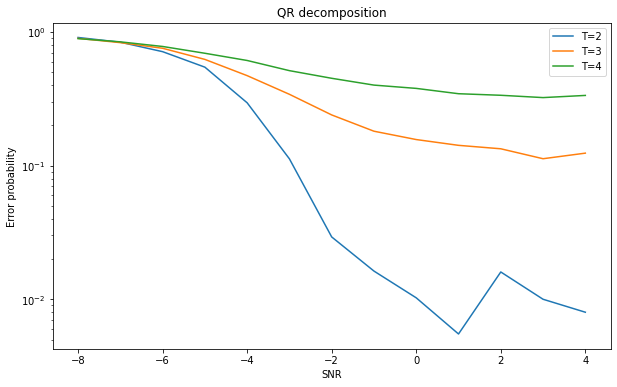

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.semilogy(SNR_array, np.reshape(Pr_error_qr, (1, np.product(Pr_error_qr.shape)))[0], label="T=2")
ax.semilogy(SNR_array, np.reshape(Pr_error_qr_T3, (1,np.product(Pr_error_qr_T3.shape)))[0],label="T=3")
ax.semilogy(SNR_array, np.reshape(Pr_error_qr_T4, (1,np.product(Pr_error_qr_T4.shape)))[0],label="T=4")

ax.set_title("QR decomposition")
ax.set_xlabel("SNR")
ax.set_ylabel("Error probability")
ax.legend()
plt.show()

For larger T the error is rather high, but still decoder can recognize words 
from their noisy sum

### 4.2 NNLS

Here we used NNLS to compare decoding perfomance for different $T$

In [ ]:
T = 3

Pr_error_nnls_T3 = np.zeros((1,len(SNR_array)))

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Non-negative least squares
        
        b_ls = np.array([nnls(A,y)],dtype=object)[0,0]
        
        cdws = nlargest(N_list, enumerate(b_ls), key=lambda x: x[1])
        cdws = sorted(cdws)
        cdw_idx = [cdws[i][0] for i in range(N_list)]  
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1] - A[:,comb[0][j,:]][:,2])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T

        set_idxs = set(comb_min)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_nnls_T3[0,i]=error/test

In [ ]:
T = 4

Pr_error_nnls_T4 = np.zeros((1,len(SNR_array)))

for i in np.arange(len(sigma_array)):
    sigma = sigma_array[i]
    error = 0
    #error_perUser = 0
    test = 0
    
    while test < num_tests:
        b = np.zeros((Mp,1))
        perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
        b[perm,0] = 1

        y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
        y = np.reshape(y, (1,np.product(y.shape)))[0]
        
        #Non-negative least squares
        
        b_ls = np.array([nnls(A,y)],dtype=object)[0,0]
        
        cdws = nlargest(N_list, enumerate(b_ls), key=lambda x: x[1])
        cdws = sorted(cdws)
        cdw_idx = [cdws[i][0] for i in range(N_list)]  
        comb = np.array([list(itertools.combinations(cdw_idx, T))])
        dist_min = 100000
        
        
        for j in np.arange(comb[0].shape[0]):
            dist = np.linalg.norm(y - A[:,comb[0][j,:]][:,0]-A[:,comb[0][j,:]][:,1] - A[:,comb[0][j,:]][:,2] - A[:,comb[0][j,:]][:,3])
            if dist_min > dist:
                dist_min = dist
                comb_min = comb[0][j,:].T

        set_idxs = set(comb_min)

        error = error + (T-len(set_idxs&set(perm)))/T     
        
        test = test+1
    Pr_error_nnls_T4[0,i]=error/test

In [ ]:
Pr_error = [0.90775, 0.83775, 0.72175, 0.54, 0.2855 , 0.1105 , 0.046  , 0.0195 , 0.0175 , 0.014  , 0.013  , 0.0095 , 0.0065 ]

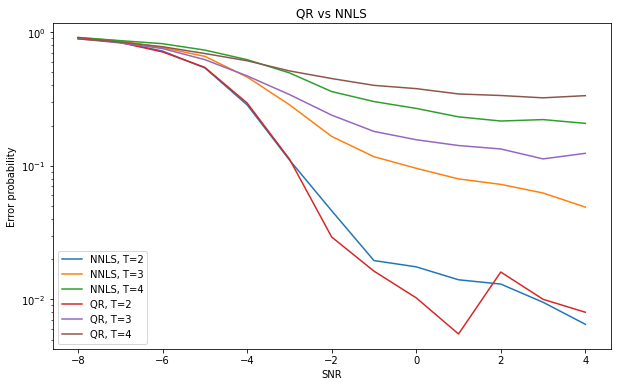

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.semilogy(SNR_array, Pr_error, label="NNLS, T=2")
ax.semilogy(SNR_array, np.reshape(Pr_error_nnls_T3, (1,np.product(Pr_error_nnls_T3.shape)))[0],label="NNLS, T=3")
ax.semilogy(SNR_array, np.reshape(Pr_error_nnls_T4, (1,np.product(Pr_error_nnls_T4.shape)))[0],label="NNLS, T=4")
ax.semilogy(SNR_array, np.reshape(Pr_error_qr, (1, np.product(Pr_error_qr.shape)))[0], label="QR, T=2")
ax.semilogy(SNR_array, np.reshape(Pr_error_qr_T3, (1,np.product(Pr_error_qr_T3.shape)))[0],label="QR, T=3")
ax.semilogy(SNR_array, np.reshape(Pr_error_qr_T4, (1,np.product(Pr_error_qr_T4.shape)))[0],label="QR, T=4")


ax.set_title("QR vs NNLS")
ax.set_xlabel("SNR")
ax.set_ylabel("Error probability")
ax.legend()
plt.show()

## 5. Time estimation

In [ ]:
%timeit np.linalg.qr(A, mode="complete")
%timeit np.linalg.pinv(R) @ np.conj(Q.T) @ y

The slowest run took 4.62 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.68 ms per loop
100 loops, best of 3: 3.93 ms per loop


In [ ]:
%timeit nnls(A,y)

100 loops, best of 3: 3.28 ms per loop


In [ ]:
%timeit least_squares(leastsq,x0, bounds=(0,1))

1 loop, best of 3: 13 s per loop


In [93]:
time_nnls = []
time_bvls = []
time_cs = []
time_qr = []
time_ls = []
for i in np.arange(len(sigma_array)):
    Mp=1024
    b = np.zeros((Mp,1))
    perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
    b[perm,0] = 1
    sigma = sigma_array[i]
    y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
    y = np.reshape(y, (1,np.product(y.shape)))[0]
    
    D = dct(A)
    x0=np.ones(1024)
    t1 = %timeit -o -q idct(lasso.fit(D, y).coef_, axis=0)
    time_cs.append(t1.average)
    t2 = %timeit -o -q lsq_linear(A, y, bounds=[0,1], method='bvls')
    time_bvls.append(t2.average)
    t3 = %timeit -o -q np.array([nnls(A,y)],dtype=object)[0,0]
    time_nnls.append(t3.average)
    t4 = %timeit -o -q Q, R = np.linalg.qr(A, mode="complete")
    t5 = %timeit -o -q np.linalg.pinv(R) @ np.conj(Q.T) @ y 
    time_qr.append(t4.average + t5.average)
    t6 = %timeit -o -q least_squares(leastsq,x0, bounds=(0,1))
    time_ls.append(t6.average)
    
    

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46832356330433006, tolerance: 0.03118441769654872
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46832356330433006, tolerance: 0.03118441769654872
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46832356330433006, tolerance: 0.03118441769654872
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46832356330433006, tolerance: 0.03118441769654872
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46832356330433006, tolerance: 0.03118441769654872
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46832356330433006, tolerance: 0.03118441769654872
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46832356330433006, tolerance: 0.03118441769654872
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46832356330433006, tolerance: 0.03118441769654872
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46832356330433006, tolerance: 0.03118441769654872
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5606133923964178, tolerance: 0.032464805521502285
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5606133923964178, tolerance: 0.032464805521502285
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5606133923964178, tolerance: 0.032464805521502285
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5606133923964178, tolerance: 0.032464805521502285
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5606133923964178, tolerance: 0.032464805521502285
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5606133923964178, tolerance: 0.032464805521502285
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5606133923964178, tolerance: 0.032464805521502285
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5606133923964178, tolerance: 0.032464805521502285
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5606133923964178, tolerance: 0.032464805521502285
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7598269637066667, tolerance: 0.014446192254420157
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7598269637066667, tolerance: 0.014446192254420157
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7598269637066667, tolerance: 0.014446192254420157
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7598269637066667, tolerance: 0.014446192254420157
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7598269637066667, tolerance: 0.014446192254420157
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7598269637066667, tolerance: 0.014446192254420157
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6843862276009061, tolerance: 0.028736398360608408
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6843862276009061, tolerance: 0.028736398360608408
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6843862276009061, tolerance: 0.028736398360608408
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6843862276009061, tolerance: 0.028736398360608408
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6843862276009061, tolerance: 0.028736398360608408
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6843862276009061, tolerance: 0.028736398360608408
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6843862276009061, tolerance: 0.028736398360608408
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6843862276009061, tolerance: 0.028736398360608408
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6843862276009061, tolerance: 0.028736398360608408
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.465280746297676, tolerance: 0.019150804332741037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.465280746297676, tolerance: 0.019150804332741037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.465280746297676, tolerance: 0.019150804332741037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.465280746297676, tolerance: 0.019150804332741037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.465280746297676, tolerance: 0.019150804332741037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.465280746297676, tolerance: 0.019150804332741037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6462122144679447, tolerance: 0.015540438016488783
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6462122144679447, tolerance: 0.015540438016488783
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6462122144679447, tolerance: 0.015540438016488783
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6462122144679447, tolerance: 0.015540438016488783
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6462122144679447, tolerance: 0.015540438016488783
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6462122144679447, tolerance: 0.015540438016488783
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6462122144679447, tolerance: 0.015540438016488783
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6462122144679447, tolerance: 0.015540438016488783
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6462122144679447, tolerance: 0.015540438016488783
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05421883613083291, tolerance: 0.009409848149820441
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05421883613083291, tolerance: 0.009409848149820441
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05421883613083291, tolerance: 0.009409848149820441
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05421883613083291, tolerance: 0.009409848149820441
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05421883613083291, tolerance: 0.009409848149820441
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05421883613083291, tolerance: 0.009409848149820441
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43587361635150695, tolerance: 0.01658718183894161
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43587361635150695, tolerance: 0.01658718183894161
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43587361635150695, tolerance: 0.01658718183894161
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43587361635150695, tolerance: 0.01658718183894161
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43587361635150695, tolerance: 0.01658718183894161
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43587361635150695, tolerance: 0.01658718183894161
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43587361635150695, tolerance: 0.01658718183894161
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43587361635150695, tolerance: 0.01658718183894161
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43587361635150695, tolerance: 0.01658718183894161
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10865429883203448, tolerance: 0.01567551429936284
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10865429883203448, tolerance: 0.01567551429936284
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10865429883203448, tolerance: 0.01567551429936284
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10865429883203448, tolerance: 0.01567551429936284
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10865429883203448, tolerance: 0.01567551429936284
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10865429883203448, tolerance: 0.01567551429936284
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10865429883203448, tolerance: 0.01567551429936284
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18327638078628422, tolerance: 0.011308574669453298
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18327638078628422, tolerance: 0.011308574669453298
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase t

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18327638078628422, tolerance: 0.011308574669453298
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18327638078628422, tolerance: 0.011308574669453298
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18327638078628422, tolerance: 0.011308574669453298
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18327638078628422, tolerance: 0.011308574669453298
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18327638078628422, tolerance: 0.011308574669453298
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18327638078628422, tolerance: 0.011308574669453298
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02503714480999649, tolerance: 0.011049113580894507
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02503714480999649, tolerance: 0.011049113580894507
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02503714480999649, tolerance: 0.011049113580894507
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02503714480999649, tolerance: 0.011049113580894507
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02503714480999649, tolerance: 0.011049113580894507
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02503714480999649, tolerance: 0.011049113580894507
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02503714480999649, tolerance: 0.011049113580894507
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02503714480999649, tolerance: 0.011049113580894507
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02503714480999649, tolerance: 0.011049113580894507
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06017820808897155, tolerance: 0.013497373985354848
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06017820808897155, tolerance: 0.013497373985354848
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06017820808897155, tolerance: 0.013497373985354848
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06017820808897155, tolerance: 0.013497373985354848
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06017820808897155, tolerance: 0.013497373985354848
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06017820808897155, tolerance: 0.013497373985354848
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024653700431043975, tolerance: 0.011270508825711066
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024653700431043975, tolerance: 0.011270508825711066
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024653700431043975, tolerance: 0.011270508825711066
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024653700431043975, tolerance: 0.011270508825711066
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024653700431043975, tolerance: 0.011270508825711066
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024653700431043975, tolerance: 0.011270508825711066
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024653700431043975, tolerance: 0.011270508825711066
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024653700431043975, tolerance: 0.011270508825711066
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024653700431043975, tolerance: 0.011270508825711066
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

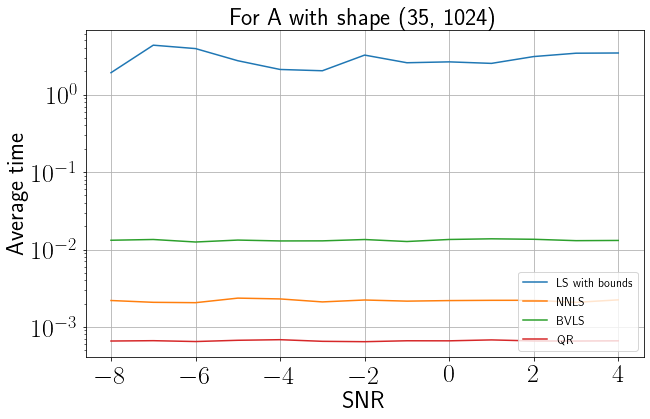

In [96]:
plt.figure(figsize=(10,6))
plt.rc("text", usetex=True)

plt.semilogy(SNR_array, time_ls, label="LS with bounds")
# plt.semilogy(SNR_array, time_cs, label="Compressed sensing")
plt.semilogy(SNR_array, time_nnls, label="NNLS")
plt.semilogy(SNR_array, time_bvls, label="BVLS")
plt.semilogy(SNR_array, time_qr, label="QR")

plt.grid()
plt.title(r"For A with shape (35, 1024)", fontsize=24)
plt.ylabel(r"Average time", fontsize=24)
plt.xlabel(r"SNR", fontsize=24)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.legend(loc=4,fontsize='large')
plt.savefig("Time_long.png")

In [44]:
A_new.shape

(35, 60)

In [49]:
time_nnls = []
time_bvls = []
time_cs = []
time_qr = []
time_ls = []
for i in np.arange(len(sigma_array)):
    Mp = A_new.shape[1]
    A = A_new
    b = np.zeros((Mp,1))
    perm = np.random.permutation(Mp)[:T] # indexes of transmitted messages
    b[perm,0] = 1
    sigma = sigma_array[i]
    y = A@b + np.array([np.random.normal(loc=0.0, scale=sigma*sigma, size=A.shape[0])]).T
    y = np.reshape(y, (1,np.product(y.shape)))[0]
    
    D = dct(A)
    x0=np.ones(60)
    t1 = %timeit -o -q idct(lasso.fit(D, y).coef_, axis=0)
    time_cs.append(t1.average)
    t2 = %timeit -o -q lsq_linear(A, y, bounds=[0,1], method='bvls')
    time_bvls.append(t2.average)
    t3 = %timeit -o -q np.array([nnls(A,y)],dtype=object)[0,0]
    time_nnls.append(t3.average)
    t4 = %timeit -o -q Q, R = np.linalg.qr(A, mode="complete")
    t5 = %timeit -o -q np.linalg.pinv(R) @ np.conj(Q.T) @ y 
    time_qr.append(t4.average + t5.average)
    t6 = %timeit -o -q least_squares(leastsq,x0, bounds=(0,1))
    time_ls.append(t6.average)
   

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23443159582377704, tolerance: 0.041792765225110766
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3128125908359767, tolerance: 0.02521236818757205
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.583509351199021, tolerance: 0.019570178241797517
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05359756158051843, tolerance: 0.012843508798909165
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08333283676401948, tolerance: 0.013249582117247811
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13502371322666273, tolerance: 0.008279598045974676
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05393914812600241, tolerance: 0.010840678201252167
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09976463453882256, tolerance: 0.008273400722157279
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018807325790281958, tolerance: 0.006365364733926839
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07389266814186563, tolerance: 0.008398661604729865
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0167123391282305, tolerance: 0.007656157809298719
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013284126121705299, tolerance: 0.008776236077826037
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increa

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016681651618622638, tolerance: 0.00909289487787043
  positive)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase 

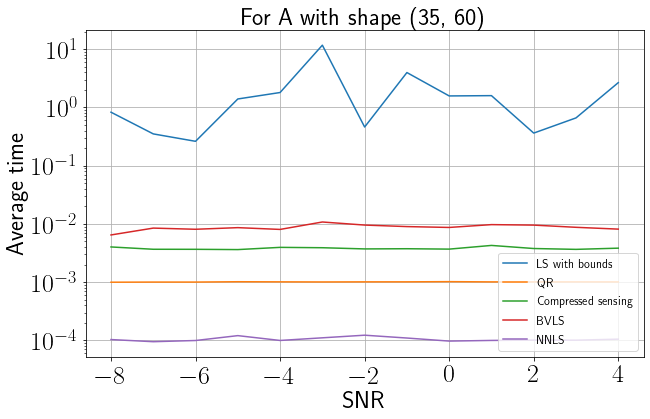

In [58]:
plt.figure(figsize=(10,6))
plt.rc("text", usetex=True)

plt.semilogy(SNR_array, time_ls, label="LS with bounds")
plt.semilogy(SNR_array, time_qr, label="QR")
plt.semilogy(SNR_array, time_cs, label="Compressed sensing")
plt.semilogy(SNR_array, time_bvls, label="BVLS")
plt.semilogy(SNR_array, time_nnls, label="NNLS")

plt.grid()
plt.title(r"For A with shape (35, 60)", fontsize=24)
plt.ylabel(r"Average time", fontsize=24)
plt.xlabel(r"SNR", fontsize=24)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.legend(loc=4,fontsize='large')
plt.savefig("Time_short.png")